# ImpDAR Getting Started Tutorial

Welcome to ImpDAR!
This is an impulse radar processor primarily targeted toward ice-penetrating radar systems. However, the potential applications of this software are much more widespread. Our goal is to provide an alternative to the expensive commercial software that would be purchased with a ground-penetrating radar system from a company such as GSSI or Sensors and Software. We provide all of the processing tools that are needed to move from a raw data file to an interpretable image of the subsurface. Moreover, our software is agnostic to the system used, so we can import data from a variety of different ground-penetrating radar systems and interact with the data in the exact same way.

If you have not yet installed ImpDAR on your computer, you can go to our github page (https://github.com/dlilien/ImpDAR) to download or clone the repository. For those less familiar with Python programming, take a look at our Read the Docs page for help (https://impdar.readthedocs.io/en/latest/).

The preferred pathway for interacting with ImpDAR is through the terminal. However, our API allows relatively easy access through other programs as well. Here, we want to walk you through the processing flow using a Jupyter Notebook, where all of the processing functions can be called through Python. No prior knowledge of Python is necessary.

## Import the necessary libraries

The very first thing to do with any Python script is to import all of the libraries that will be used. These will allow us to call functions that help with loading scripts, some numerical issues, and plotting. Knowing exactly what each of these are is not important to understanding the radar processing flow. 

In [1]:
# We get annoying warnings about backends that are safe to ignore
import warnings
warnings.filterwarnings('ignore')

# Standard Python Libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

## Load the raw data

With the standard libraries loaded, we can now look at some radar data. This particular radargram was collected at the Northeast Greenland Ice Stream (Christianson et al., 2014). We discuss more of the details about exactly what we are looking at when we get to a more interpretable image. 

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910f0cd6a0>)

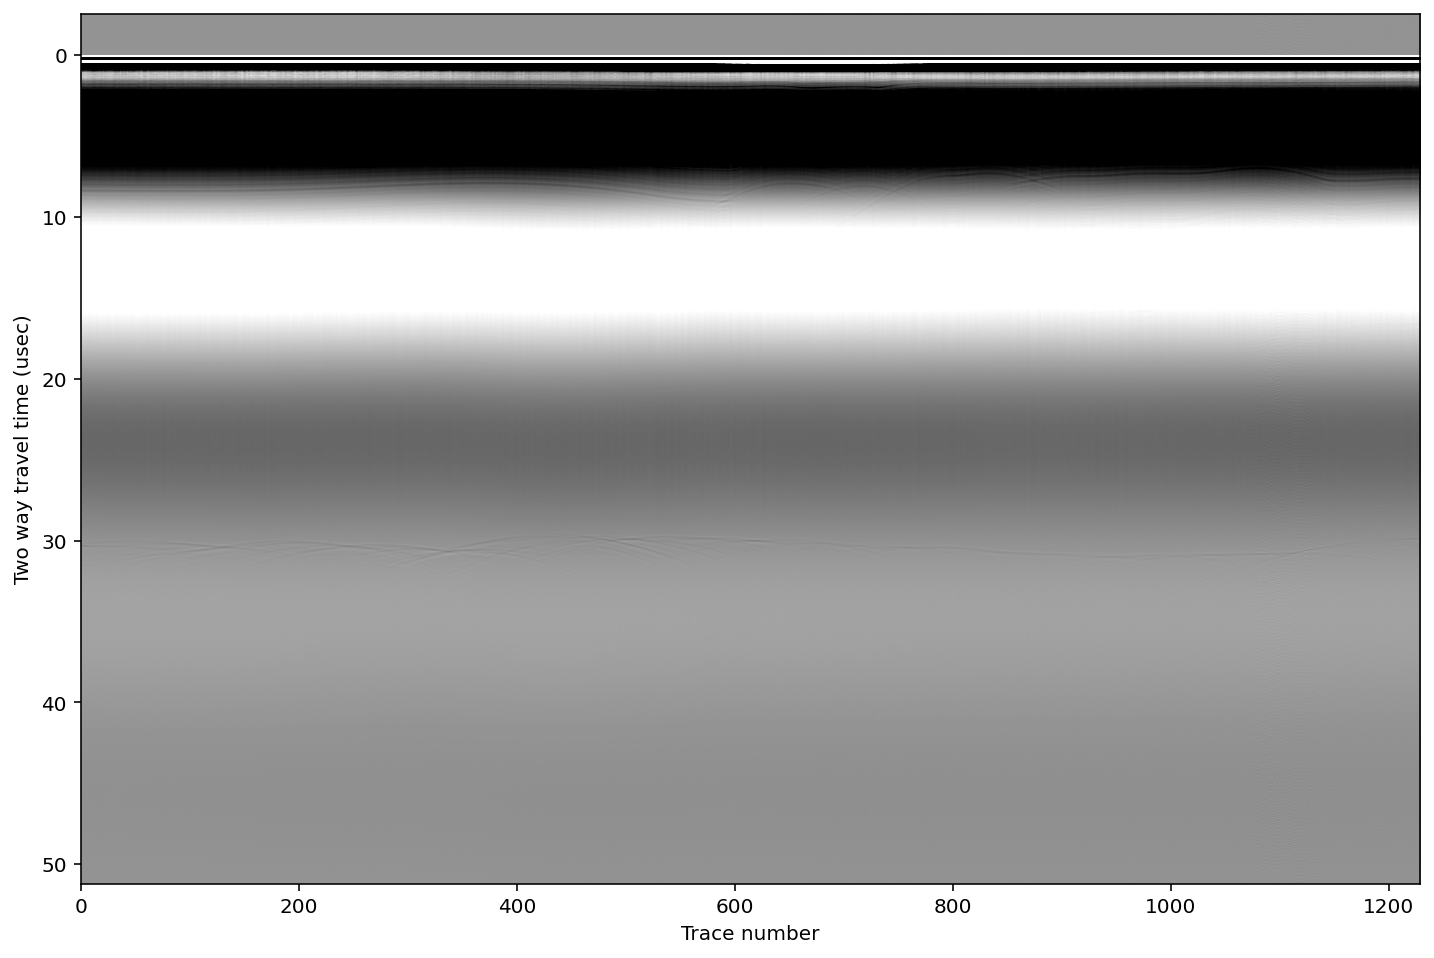

In [2]:
# To look through data files we use glob which is a library 
# that finds all the file names matching our description
import glob
files = glob.glob('data_in/*[!.gps]')

# Impdar's loading function
from impdar.lib import load
dat = load.load_olaf.load_olaf(files)
# save the loaded data as a .mat file
dat.save('test_data_raw.mat')

# Impdar's plotting function
from impdar.lib.plot import plot_traces, plot_radargram
%matplotlib inline
plot_radargram(dat)

Raw radar data are a mess. We can't really see anything meaningful here. 

In order to illustrate the first processing step, let's plot a single 'trace'. A radar trace is one collection of voltages measured by the oscilloscope through time. The total time for collection in this case is ~50 microseconds. 

(<Figure size 576x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910c8ff978>)

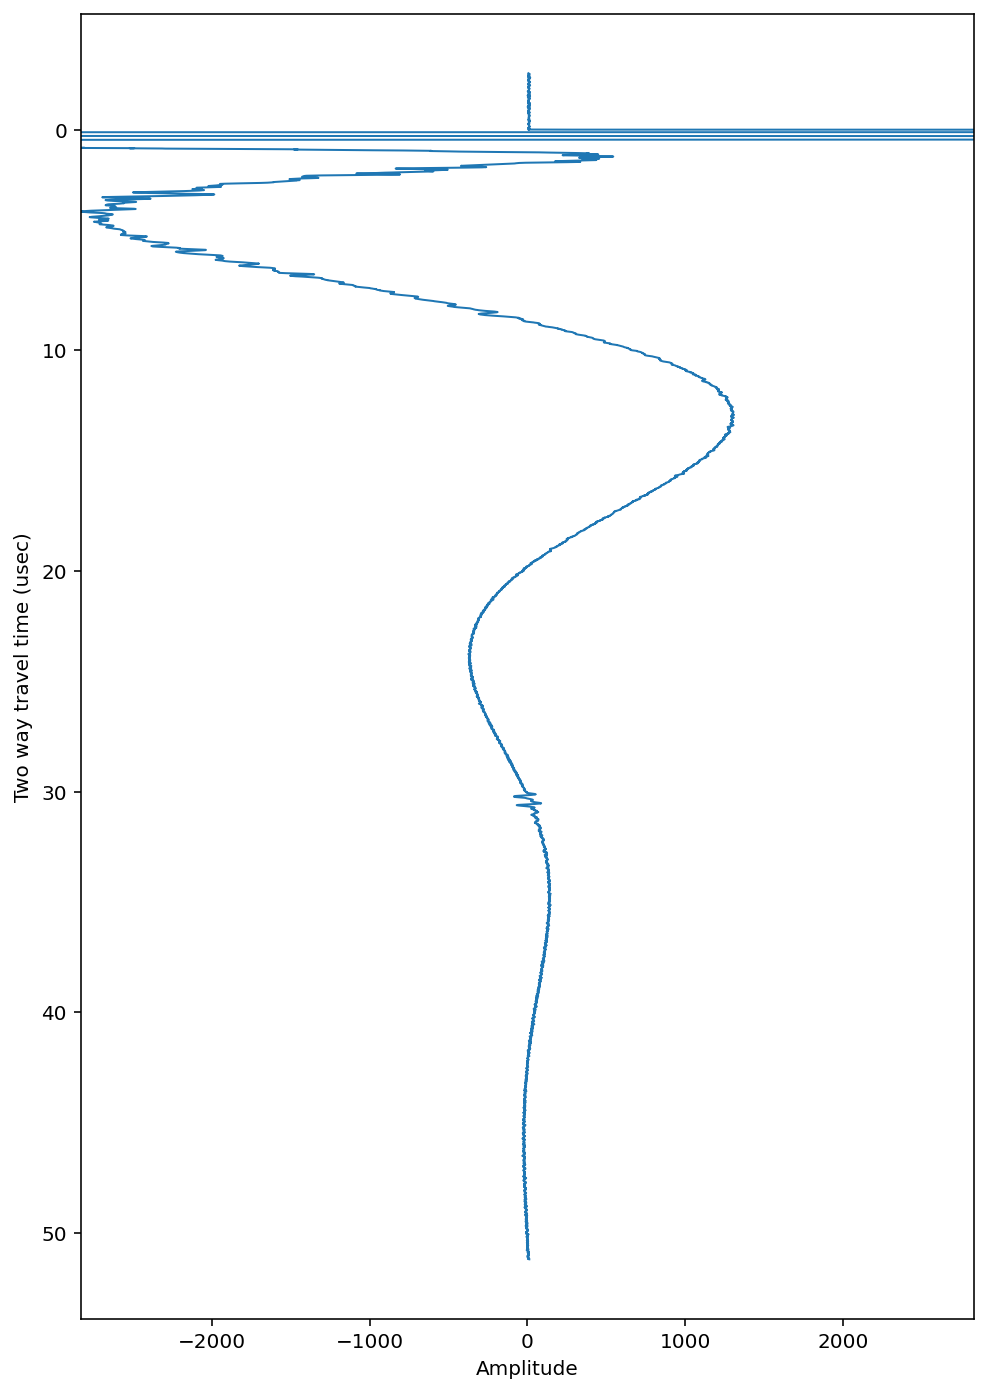

In [3]:
### Try changing the trace index to see whether they are similar or different ###
### Make sure that you understand the relationship between this figure and above ###

# Reload in case a lower cell gets run
dat = load.load_olaf.load_olaf(files)

# Plot a single trace, where tr is the trace number in the above image
plot_traces(dat,tr=100)

## Bandpass filter

The first big processing step is to isolate the frequency band of interest. The radar antennas set this frequency. In our case, the antennas are ~20 m long (frequency of 3 MHz) so we want to allow the frequency band from 1-5 MHz pass while damping all other frequencies (i.e. bandpass filter). 

This filter works on all the traces simultaneously, but to illustrate its effect we will plot the single trace again.

Bandpassing from  1.0 to  5.0 MHz...
Bandpass filter complete.


(<Figure size 576x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910c8ff668>)

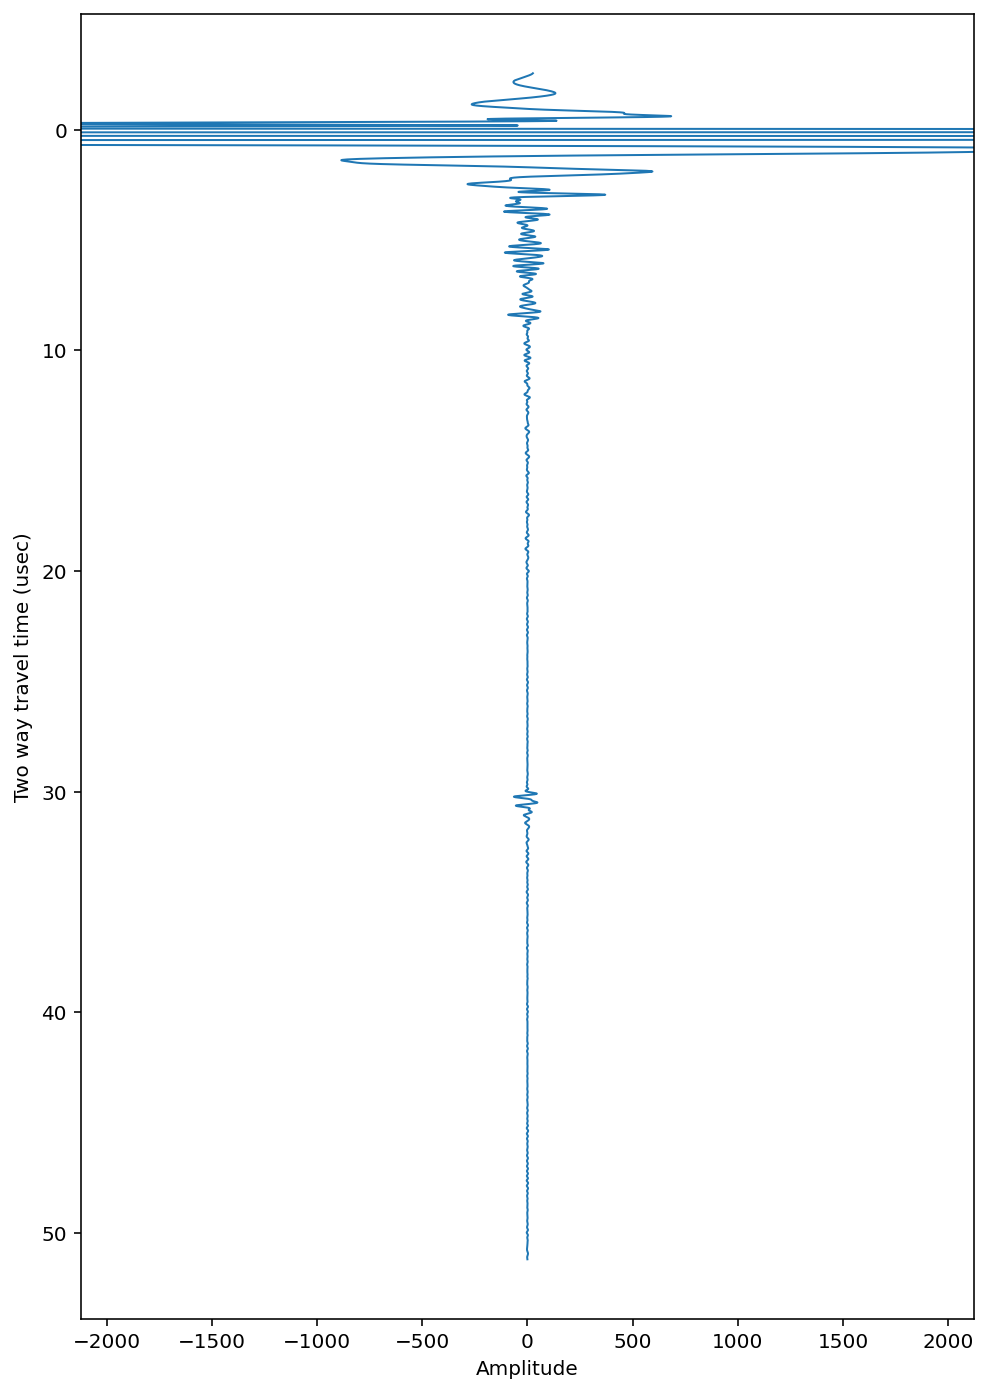

In [4]:
# Do the vertical bandpass filter from 1-5 MHz
dat.vertical_band_pass(1,5)
# save again
dat.save('./test_data_bandpassed.mat')

# Plot a single trace
plot_traces(dat, tr=100)

Now plot the entire image again.

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910c7fd1d0>)

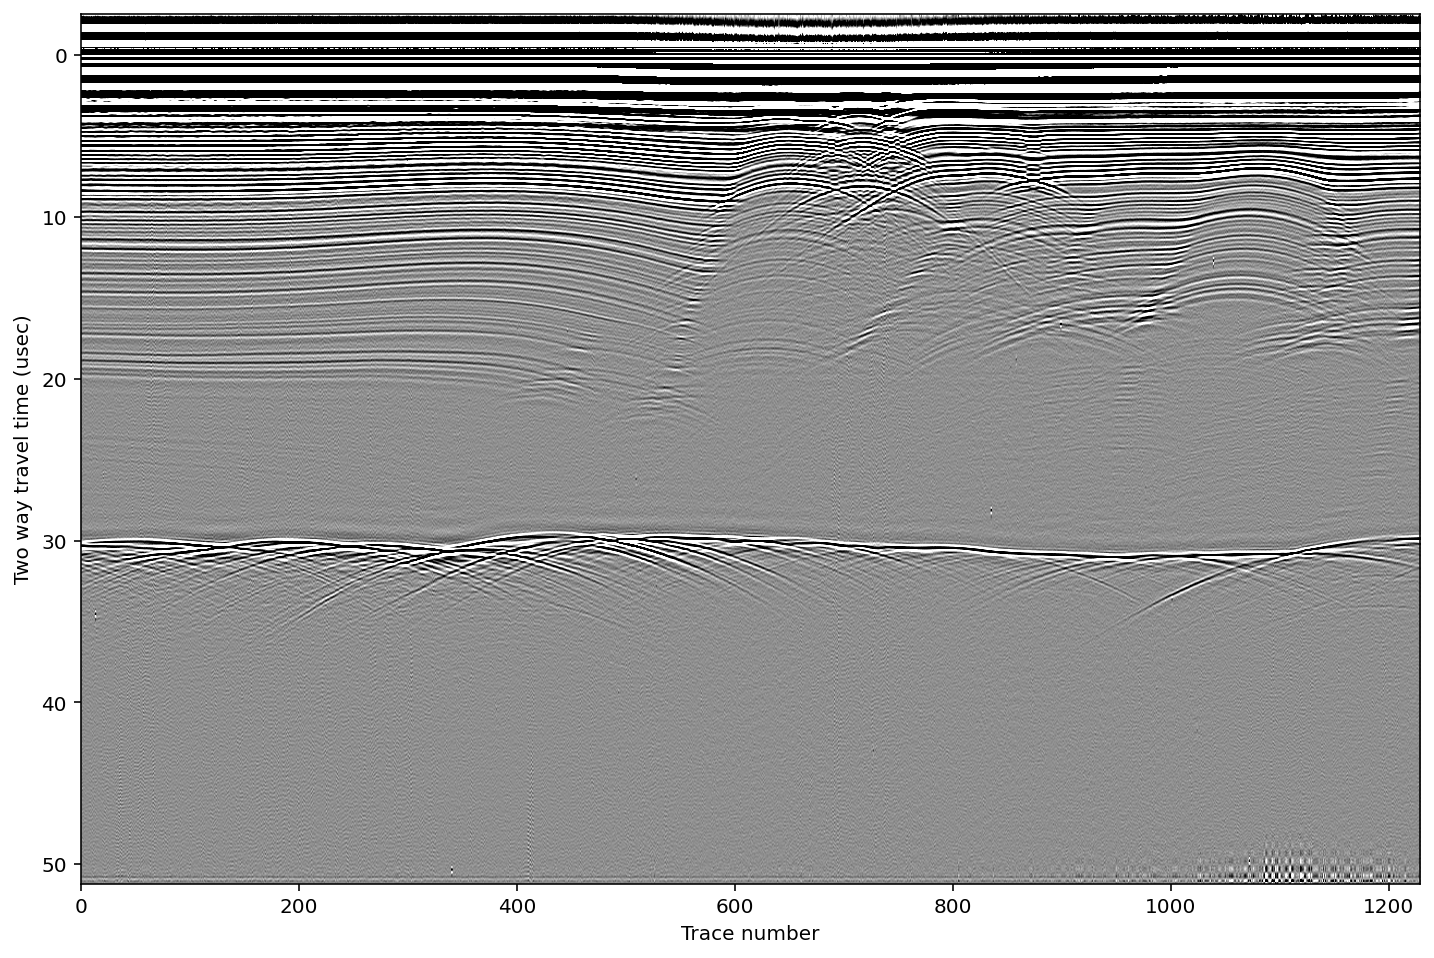

In [5]:
# Plot all the bandpassed data
plot_radargram(dat)

## Geometric Corrections

Now that the data look like something useful, we can do a few more corrections to make it more physical. Two geometric corrections allow us to look at the image more like something under the surface instead of in this two-way travel time dimension that we have been using. First we crop out the 'pretrigger' which is data collected by the receiver before the radar pulse is actually transmitted. Second we do a 'normal move-out' correction (nmo) which corrects for the separation distance between the receiving and transmitting antennas. We have an additional tutorial for more details about the nmo filter in the case of a variable velocity (e.g. in snow or firn). After the nmo correction, we can more responsibly plot the y axis in 'depth' rather than 'travel time' by adding 'yd=True' in the plot function.

Vertical samples reduced to subset [512:10752] of original


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910c7daa90>)

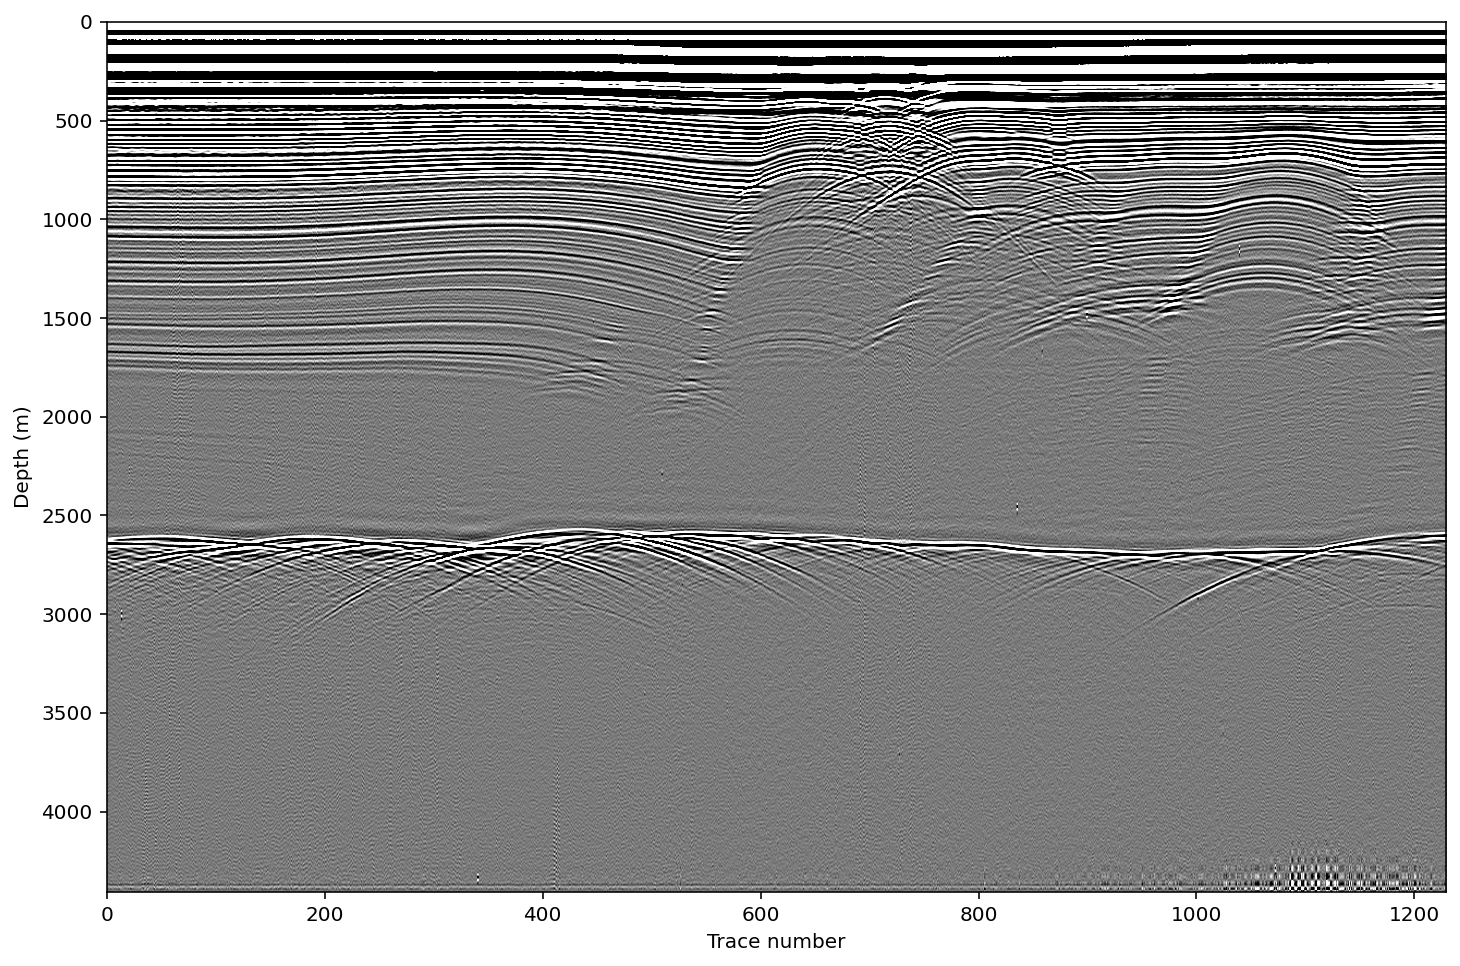

In [6]:
# Crop the pretrigger out from the top of each trace
dat.crop(0.,dimension='pretrig')
# Do the normal move-out correction with antenna spacing 160 m
dat.nmo(160)

# Save and plot
dat.save('test_data_nmo.mat')
plot_radargram(dat, ydat='depth')

## Georeferencing and Interpolation

Up to now, everything has been plotted as 'trace number' in the horizontal. In reality though, we want to know where in space each trace was measured. Typically, these data are collected with some kind of GPS either internal to the system itself, or attached as an external antenna.

In cases where the GPS data are available, ImpDAR can load the data in, assigning lat/long to each trace. Then, the coordinates can be projected into x/y and a distance vector created for distance traversed along the profile. The final step is to interpolate the image onto equal trace spacing. All this is handled in the 'interp' function as seen below.

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910c790be0>)

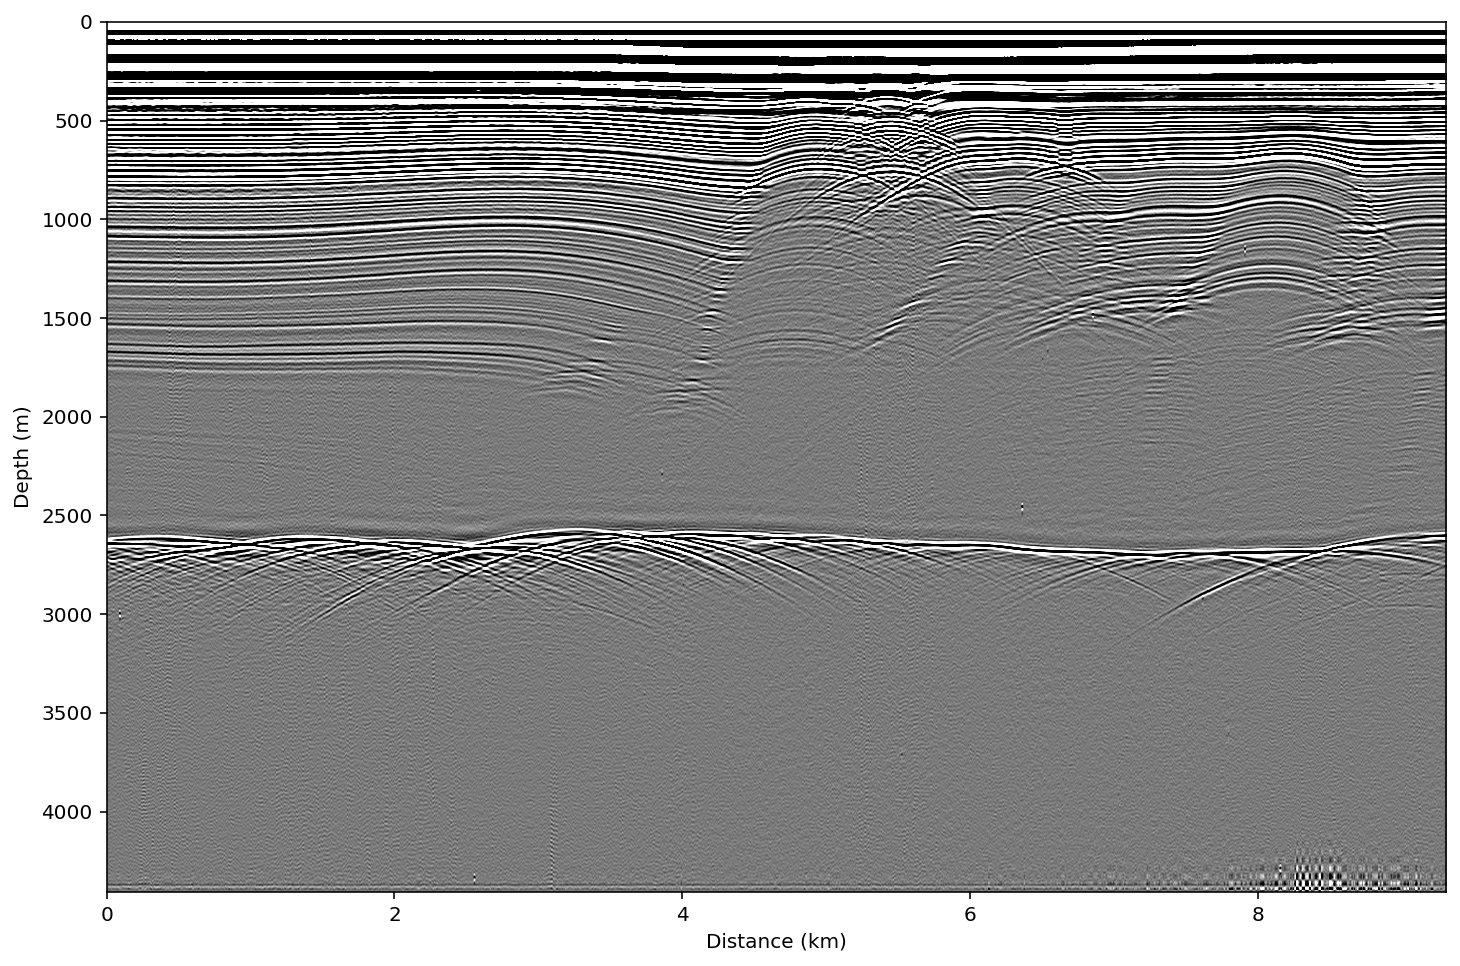

In [7]:
# Interpolate onto equal trace spacing of 5 m
from impdar.lib.gpslib import interp
interp([dat],5)

# Save and plot the interpolated image
dat.save('test_data_interp.mat')
plot_radargram(dat,ydat='depth',xdat='dist')

## Denoise

Denoising is done with a 2-dimensional Wiener filter. Inputs are the number of pixels to include in the filter (vertical, horizontal).

**Note: After denoising the image, the wave amplitude no longer has a physical meaning. For amplitude analysis, denoising filters should be avoided.

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910c720748>)

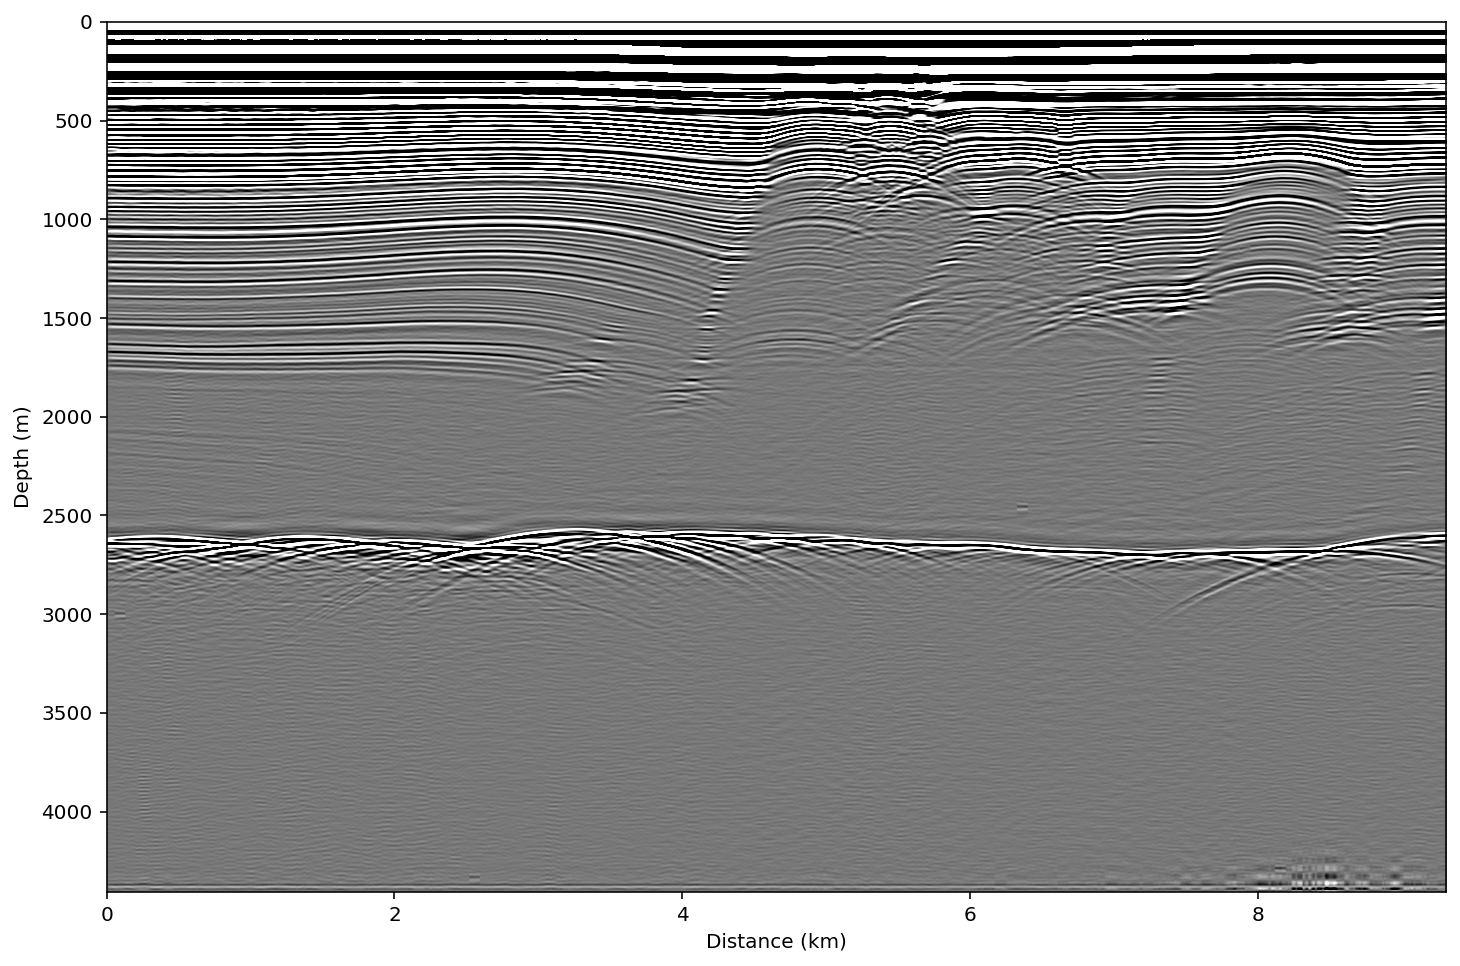

In [8]:
dat.denoise(1,15)

# Save and plot
dat.save('test_data_denoise.mat')
plot_radargram(dat,ydat='depth',xdat='dist')

## Linear Range Gain

Sometimes, when the data are very low amplitude near the bed, we want to boost the signal so that we can see it. The simplest way to do this is with a linear range gain (i.e. multiply each trace by a ramp that increases toward the bottom). 

**Note: As with the denoising filter above, amplitude interpretations should not be done after this type of filter has been used.

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f910c6e0d30>)

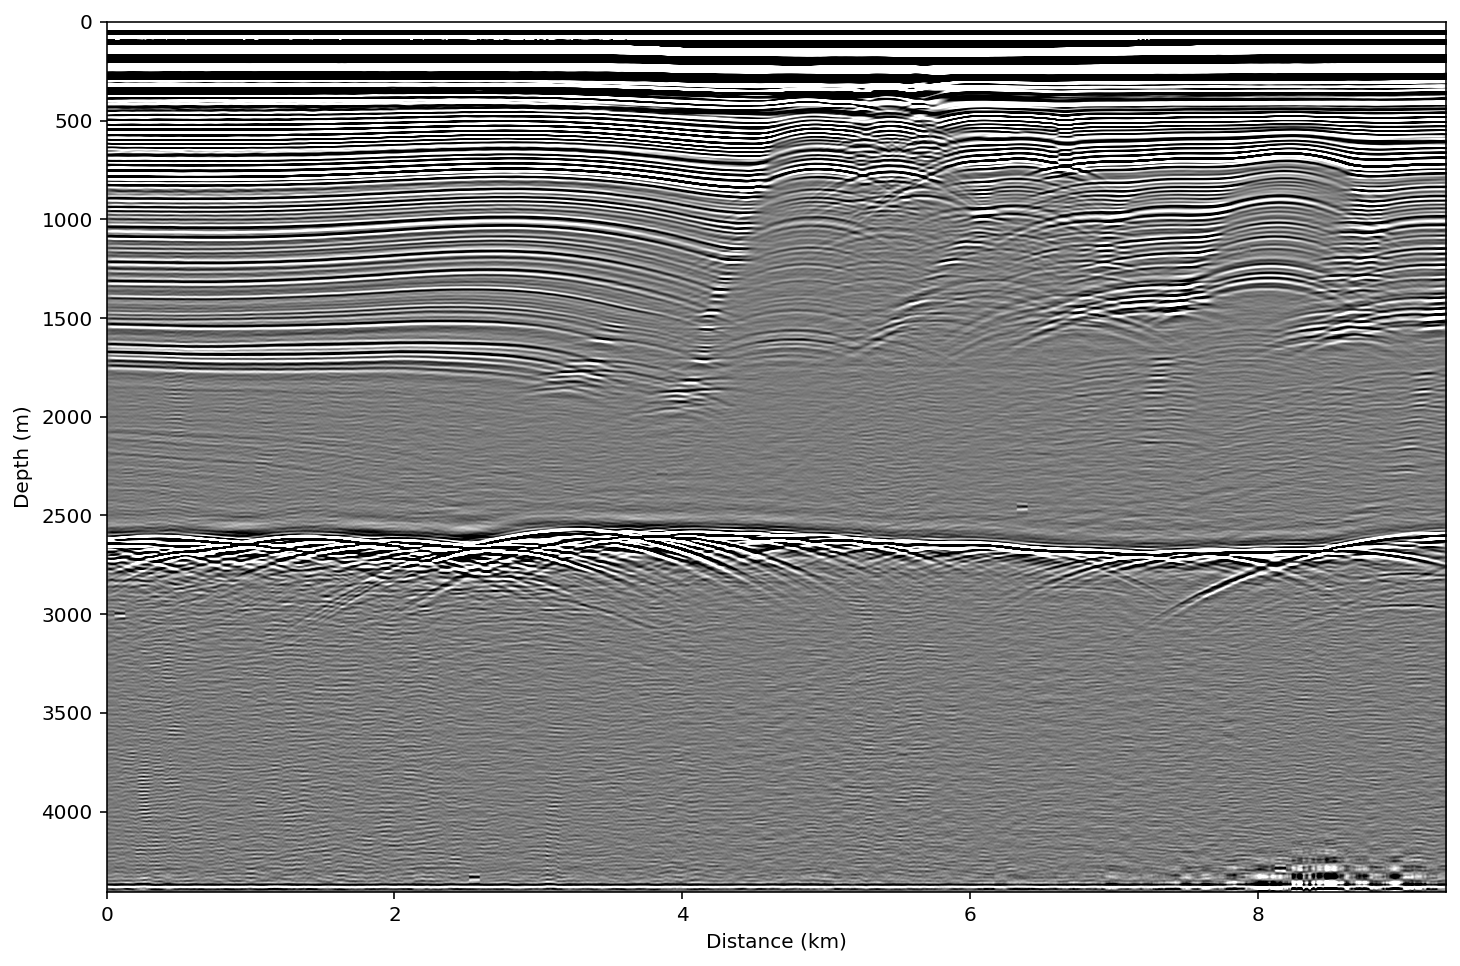

In [9]:
dat.rangegain(0.05)

# Save and plot
dat.save('test_data_gain.mat')
plot_radargram(dat,ydat='depth', xdat='dist')